In [1]:
# Import libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization
import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from tensorflow.keras import layers

# Part 1 - Classification of the cell type out of 8 possible types

## Load Data-Set
colorectal histology DS

In [2]:
(train_, validation_), info  = tfds.load(
    'colorectal_histology',
    split=['train[:90%]', 'train[90%:]'], 
    shuffle_files=True, 
    as_supervised=True,
    with_info=True
)


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteX6MTJU/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


 Preview 5 examples from the validation dataset

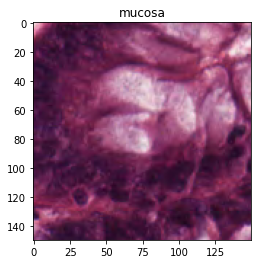

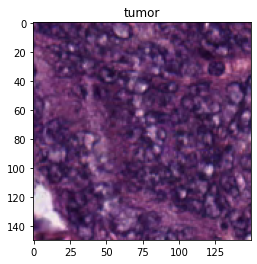

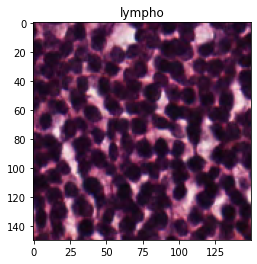

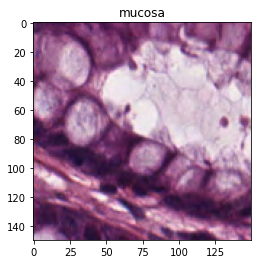

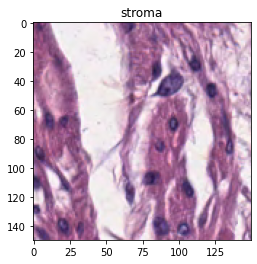

In [3]:

get_label_name = info.features['label'].int2str
for image, label in validation_.take(5):
  plt.figure()
  plt.imshow(np.array(image))
  plt.title(get_label_name(label))

In [4]:
# Input shape
info.features['image']

Image(shape=(150, 150, 3), dtype=tf.uint8)

In [5]:
def label_format(image, label):
  return (image, tf.one_hot(label, depth=8))

train = train_.map(label_format)
validation = validation_.map(label_format)

train_batch = train.shuffle(4500)
for image_batch, label_batch in train_batch.take(1): pass
image_batch = np.expand_dims(image_batch,0)
image_batch.shape

(1, 150, 150, 3)

In [6]:
train = train.shuffle(4500).batch(32)
validation = validation.batch(32)

## Generic method

###  Compile and train the model

In [7]:
def compile_and_train_the_model(model, epochs_num, opt, loss_kind):
    # compile the model:
    model.compile(optimizer=opt,
                  loss=loss_kind,
                  metrics=['accuracy'])

    # train the model - with validation
    history = model.fit(
      train,
      validation_data=validation,
      verbose=0,
      epochs=epochs_num
)
    
    return history

### Plot Graphs

In [23]:
def plot_perfomance(history_num):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history_num.history['loss'],'r')
  plt.plot(history_num.history['val_loss'],'b')
  plt.title('Loss',fontsize=14)
  plt.xlabel('Epochs',fontsize=14)
  plt.legend(('loss','val_loss'))
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(history_num.history['accuracy'],'r')
  plt.plot(history_num.history['val_accuracy'],'b')
  plt.ylim([0, 1])
  plt.legend(('accuracy','val_accuracy'))
  plt.title('Accuracy',fontsize=12)
  plt.xlabel('Epochs',fontsize=12)
  plt.grid()

## The Models

## Regular Data

#### Model 1
Block1: 32-Conv2D + 32-Conv2D + MaxPooling

Block2: 64-Conv2D + 64-Conv2D + MaxPooling

Block3: 128-Conv2D + 128-Conv2D + MaxPooling

Block4: 512-Dense + Dropout(0.5)

Block5: 8-Dense

In [8]:
model1 = Sequential()
model1.add(Conv2D(32,kernel_size = (3,3), activation='relu',padding='same', input_shape=(150, 150, 3)))
model1.add(Conv2D(32,kernel_size = (3,3), activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))


model1.add(Conv2D(64,kernel_size = (3,3), activation='relu',padding='same'))
model1.add(Conv2D(64,kernel_size = (3,3), activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))


model1.add(Conv2D(128,kernel_size = (3,3), activation='relu',padding='same'))
model1.add(Conv2D(128,kernel_size = (3,3), activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(8, activation='softmax'))
model1.summary()


loss_kind=tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
history1 = compile_and_train_the_model(model1, 20, opt, loss_kind)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 128)       7

##### Plot performance

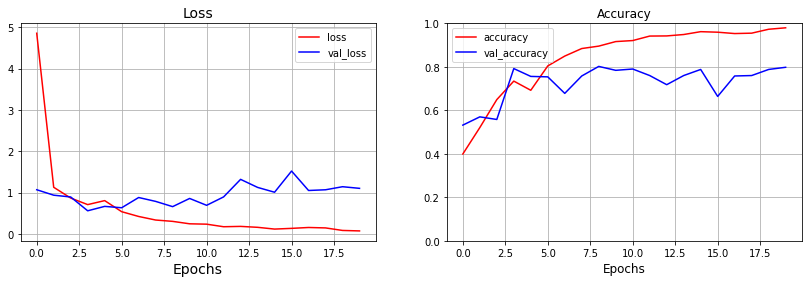

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history1.history['loss'],'r')
plt.plot(history1.history['val_loss'],'b')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(('loss','val_loss'))
plt.grid()

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'],'r')
plt.plot(history1.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.legend(('accuracy','val_accuracy'))
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.grid()


#### Model 2
Fine - tuning pre-trained VGG:

Sequential model:

First layer - pre-trained VGG16 model (without its "top")

New top: Flatten(), 256-Dense (ReLU), Dropout(0.5), 8-Dense (Softmax) freeze the weights in the first layer (of the new model (= the pre-trained VGG16 model)

Optimizer = Adam

In [8]:
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model2 = Sequential(vgg_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(8, activation='softmax'))
model2.layers[0].trainable = False
model2.summary() # 2,099,464 trainable parameters

loss_kind=tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
history2 = compile_and_train_the_model(model2, 20, opt, loss_kind)


80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 2,099,464
Non-trainable params: 20,024,384
_________________________________________________________________


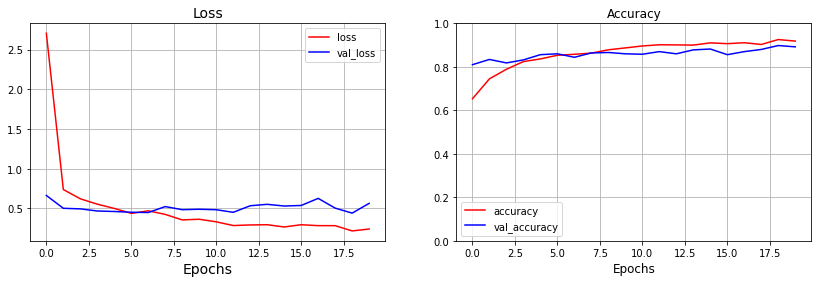

In [9]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history2.history['loss'],'r')
plt.plot(history2.history['val_loss'],'b')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(('loss','val_loss'))
plt.grid()

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'],'r')
plt.plot(history2.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.legend(('accuracy','val_accuracy'))
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.grid()


### Model 3
Fine - tuning pre-trained VGG:

Sequential model:

First layer - pre-trained VGG16 model (without its "top")

New top: Flatten(), 256-Dense (ReLU), Dropout(0.5), 8-Dense (Softmax)
freeze the weights in the first layer (of the new model (= the pre-trained VGG16 model)

Optimizer = SGD


In [10]:
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model3 = Sequential(vgg_model)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(8, activation='softmax'))
model3.layers[0].trainable = False
model3.summary() # 2,099,464 trainable parameters
loss_kind=tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
history3 = compile_and_train_the_model(model3, 20, opt, loss_kind)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 2,099,464
Non-trainable params: 20,024,384
_________________________________________________________________


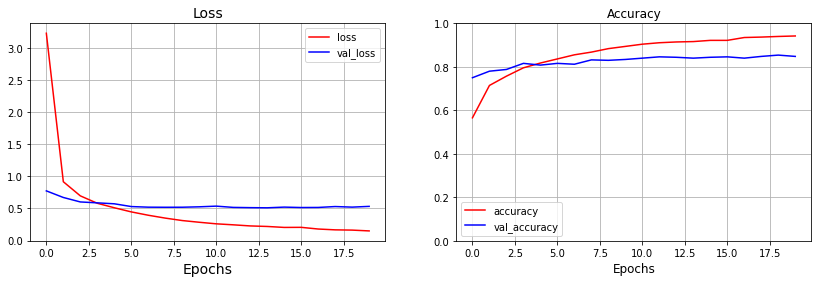

In [11]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(history3.history['loss'],'r')
plt.plot(history3.history['val_loss'],'b')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(('loss','val_loss'))
plt.grid()

plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'],'r')
plt.plot(history3.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.legend(('accuracy','val_accuracy'))
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.grid()


## Data Augmentation

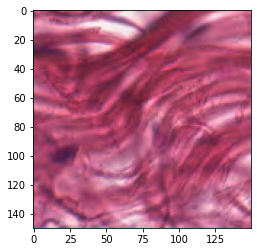

In [12]:


num_classes = info.features['label'].num_classes

get_label_name = info.features['label'].int2str
image, label = next(iter(train_))

IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])
result = resize_and_rescale(image)
plt.imshow(result)

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
])

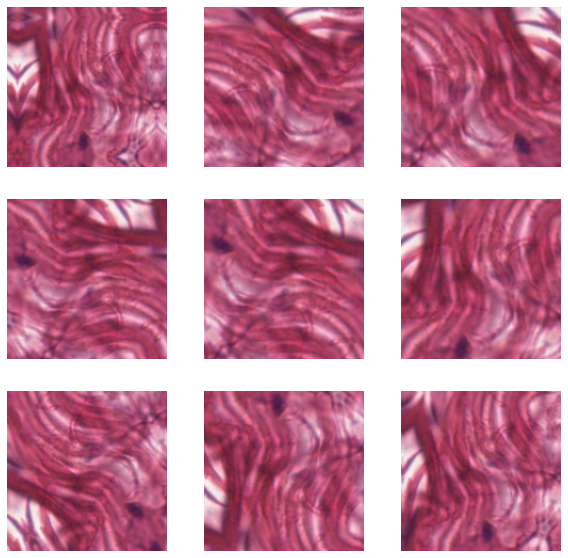

In [14]:
image = tf.expand_dims(image, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [15]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(4500)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_, shuffle=True, augment=True)
val_ds = prepare(validation_)

### Model 4
Model 2 + Data Augmentation

In [17]:
# Rebuilding model 3
vgg_model = tf.keras.applications.VGG19(
           include_top=False, input_shape=((150, 150, 3)))

model4 = Sequential(vgg_model)
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(8, activation='softmax'))
model4.layers[0].trainable = False
model4.summary() # 2,099,464 trainable parameters


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 2056      
Total params: 22,123,848
Trainable params: 2,099,464
Non-trainable params: 20,024,384
_________________________________________________________________


In [18]:

model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
history4 = model4.fit(
  
  train_ds,
  validation_data=val_ds,
  verbose=0,
  epochs=20
)

In [21]:
# history5 = model3.fit(
#   train_ds,
#   validation_data=val_ds,
#   verbose=0,
#   epochs=20
# )

#### Plot performance

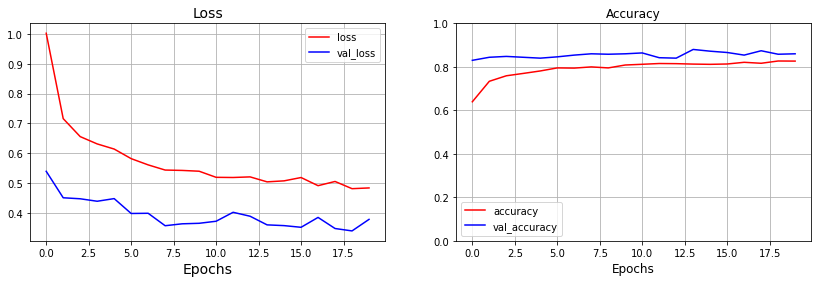

In [24]:
plot_perfomance(history4)

In [ ]:
# plot_perfomance(history5)

## Compare models performance

### Plot Perfomance

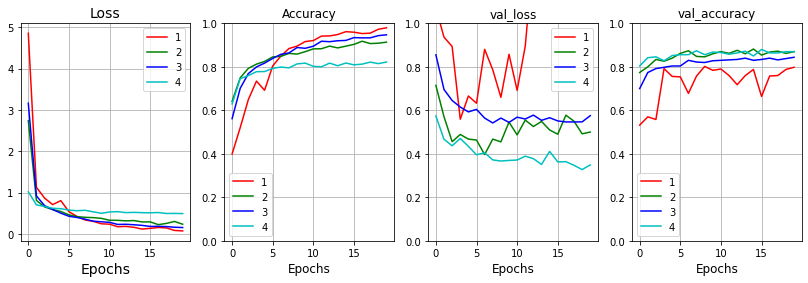

In [25]:
# kind = ['loss','accuracy','val_loss','val_accuracy']
# color = ['r','g','b','c']
# history_list = [history1, history2, history3, history4]

# plt.figure(figsize=(10, 10))
# for i in range(4):
#   ax = plt.subplot(2, 2, i + 1)
#   plt.plot(history_list[i].history[kind[i]],color[i],label = str(i+1))
#   plt.axis("off")
  
plt.subplot(1,4,1)
plt.plot(history1.history['loss'],'r',label = "1")
plt.plot(history2.history['loss'],'g',label = "2")
plt.plot(history3.history['loss'],'b',label = "3")
plt.plot(history4.history['loss'],'c',label = "4")
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend(('1','2','3','4'))
plt.grid()

plt.subplot(1,4,2)
plt.plot(history1.history['accuracy'],'r',label = "1")
plt.plot(history2.history['accuracy'],'g',label = "2")
plt.plot(history3.history['accuracy'],'b',label = "3")
plt.plot(history4.history['accuracy'],'c',label = "4")
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(('1','2','3','4'))
plt.grid()

plt.subplot(2,4,1)
plt.plot(history1.history['val_loss'],'r',label = "1")
plt.plot(history2.history['val_loss'],'g',label = "2")
plt.plot(history3.history['val_loss'],'b',label = "3")
plt.plot(history4.history['val_loss'],'c',label = "4")


plt.ylim([0, 1])
plt.title('val_loss',fontsize=12)
plt.xlabel('Epochs',fontsize=12)
plt.legend(('1','2','3','4'))
plt.grid()

plt.subplot(2,4,1)
plt.plot(history1.history['val_accuracy'],'r',label = "1")
plt.plot(history2.history['val_accuracy'],'g',label = "2")
plt.plot(history3.history['val_accuracy'],'b',label = "3")
plt.plot(history4.history['val_accuracy'],'c',label = "4")

plt.ylim([0, 1])
plt.title('val_accuracy',fontsize=12)
plt.legend(('1','2','3','4'))
plt.xlabel('Epochs',fontsize=12)
plt.grid()

### Comparation Table

<table>
  <tr>
    <th>Model</th>
    <th>Epochs</th>
    <th>Train accuracy</th>
    <th>Test accuracy</th>
  </tr>
    
  <tr> 
    <td> Model 1 </td>   <!-- Model -->
    <td>20</td> <!-- epochs -->
    <td>  0.9133</td> <!-- train accuracy -->
    <td> 0.7440</td> <!-- test accuracy -->
  </tr>

    
   <tr> 
    <td> Model 2 </td>   <!-- Model -->
    <td>20</td> <!-- epochs -->
    <td> 0.9707</td> <!-- train accuracy -->
    <td> 0.6620</td> <!-- test accuracy -->
  </tr>


  <tr> 
    <td> Model 3  </td>   <!-- Model -->
    <td>20</td> <!-- epochs -->
    <td>0.9224  </td> <!-- train accuracy -->
    <td>0.8440</td> <!-- test accuracy -->
  </tr>
  
  <tr> 
    <td> Model 4 </td>   <!-- Model -->
    <td>20</td> <!-- epochs -->
    <td>0.8351 </td> <!-- train accuracy -->
    <td>0.8600</td> <!-- test accuracy -->
  </tr>
</table>

          CONCLUSION:
          The 4'th model - which is Model_3 Using data augmentatiom,
          gaind the lowest overfitting and the best 'test accuracy' rate.


## Model 3 performance

In [25]:


true_label = []
for image, label in validation_:
  true_label.append(label)
  

In [28]:
true_label = np.asarray(true_label)

In [27]:
y_pred = np.argmax(model4.predict(prepare(validation_)),axis=1)


In [29]:
M = confusion_matrix(true_label,y_pred)
M

array([[35,  3,  3, 10,  1,  6,  5,  4],
       [ 3, 26,  6,  9,  5,  1,  3,  5],
       [ 9,  5, 24, 11,  6,  3,  3,  7],
       [ 8,  7,  6, 26,  8,  2,  4,  2],
       [ 4,  6,  3,  7, 35,  2,  4,  7],
       [ 9,  2,  2,  8,  3, 26,  4,  6],
       [ 5,  4,  2,  8,  1,  3, 29,  5],
       [ 5,  8,  2,  4,  4,  6,  6, 24]])

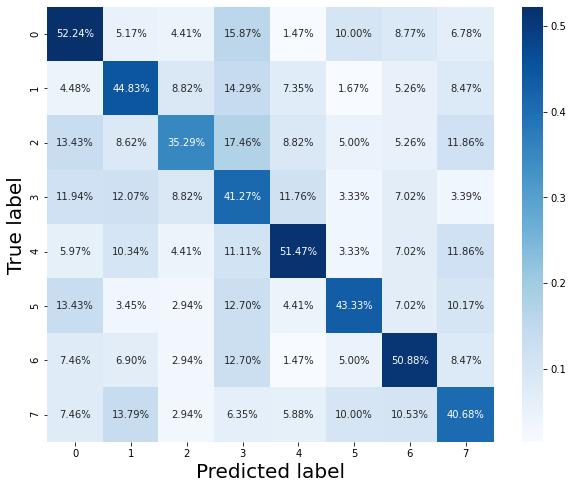

In [30]:
CM = M / M.sum(axis=1) # normalize each row (to sum = 1)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

In [31]:
features_extractor = keras.Model(inputs=model4.inputs, outputs=model4.layers[-2].output)
features_4096D = features_extractor.predict(prepare(validation_))
# features_4096D = features_4096D.reshape(-1, 1)
features_2D = TSNE(n_components=2).fit_transform(features_4096D)


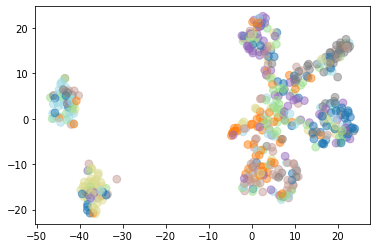

In [32]:
plt.scatter(features_2D[:,0], features_2D[:,1], s=60, c=true_label,
            cmap='tab20', alpha=0.5)


plt.show()

# **Part 2**

In [33]:
dataset, info = tfds.load(
    'ColorectalHistologyLarge',
    split=['test'],
    with_info=True
)


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology_large/2.0.0.incompleteKY5TEV/colorectal_histology_large-test.tfrecord


Dataset colorectal_histology_large downloaded and prepared to /root/tensorflow_datasets/colorectal_histology_large/2.0.0. Subsequent calls will reuse this data.


In [34]:
image = next(iter(dataset))
images_list = []
for im in image:
  images_list.append((np.asarray(im['image'])))

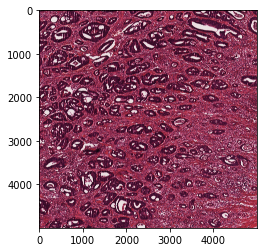

In [35]:
plt.imshow(images_list[1])

In [202]:
len(images_list)

10

In [199]:
seg_images_list = []
cmap_images_list = []
# Create 8-size list of color, for each label in the dataset
color_list=[(255, 0, 0), (255, 0,255) ,(255,255,255),(0,255, 0),	(0, 0,255),(255,255, 0),	(0,255,255),(0, 0,0)]	
for im in range(len(images_list)):
  large_image = np.asarray(images_list[im])
  large_image = np.reshape(large_image,(5000, 5000,3))
  # Create segment image of zeros
  seg_im = np.zeros_like(large_image)
  # Create colormap image of zeros
  cmap_im = np.zeros_like((large_image))

  larger_image = np.pad(large_image,((50,50),(50,50),(0,0)))
  for i in range(0, large_image.shape[0], 75):
    for j in range(0, large_image.shape[1],75):
      
      single_patch_img = larger_image[i:150+i,j:150+j,:]
      single_patch_img = resize_and_rescale(single_patch_img)
      single_patch_img = np.expand_dims(single_patch_img,0)
      single_prediction = model4.predict(single_patch_img)

      for ind in range(3):
        # Add the class label color into the sement image
        seg_im[i:i+150,j:j+150,ind] = color_list[np.argmax(single_prediction)][ind]
        cmap_im[i:i+150,j:j+150,ind] = 255 - single_prediction[0][ind]*255
        # Add the Tumer label probabil into the cmap image
        

  
  seg_images_list.append(seg_im)
  cmap_images_list.append(cmap_im)

https://www.youtube.com/watch?v=7IL7LKSLb9I

## Plot labels

In [451]:

def plot_images(cmap1, colored_images_list, flag):
  for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # fig.suptitle('Horizontally stacked subplots')
    ax1.imshow(images_list[i])
    ax1.set_title("Original img")
    gray = cv2.cvtColor(colored_images_list[i], cv2.COLOR_BGR2GRAY)
    img=ax2.imshow(gray, cmap=cmap1)
    ax2.set_title("Labeled img")
    if(flag!=0): ax2.set_title("Tumor Probability img")
    # v1 = np.linspace(seg_images_list[i].min(), seg_images_list[i].max(), 8, endpoint=True)
    values = ['0 - Tumor','','','','','8']
    if(flag!=0):
      linespace = (colored_images_list[i].max()/255)/8
      values = [0.0]
      for j in range(8): values.append(values[j]+linespace)
    cb = fig.colorbar(img,ax=ax2, spacing = 'proportional', filled = True)
    
    if(flag!=0): cb.ax.set_yticklabels(["{:4.2f}".format(i) for i in values])
    else: cb.ax.set_yticklabels(values)

  
    plt.show()


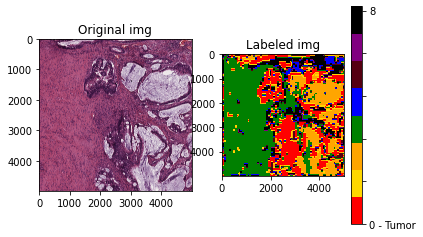

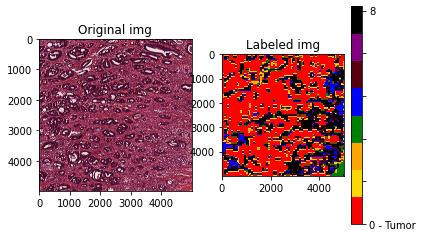

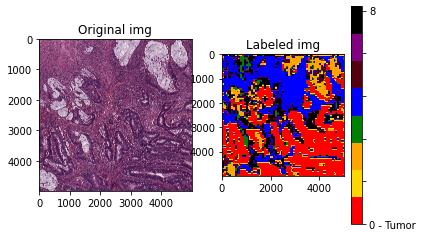

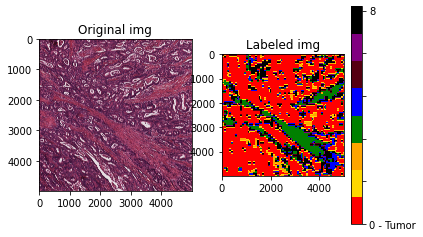

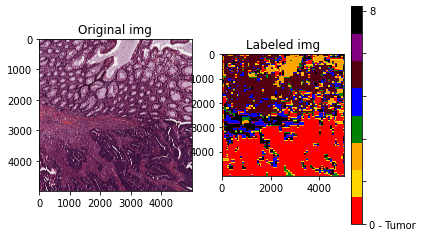

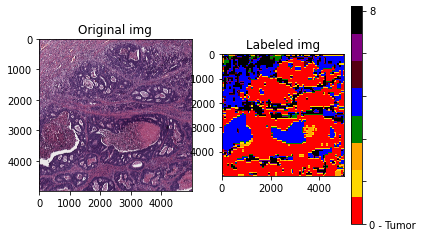

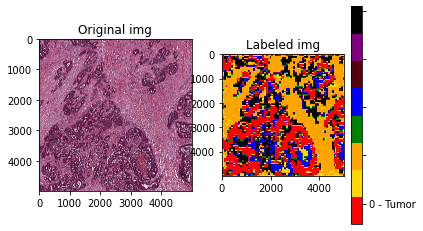

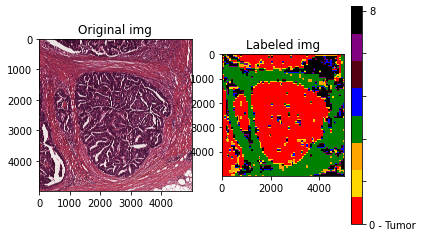

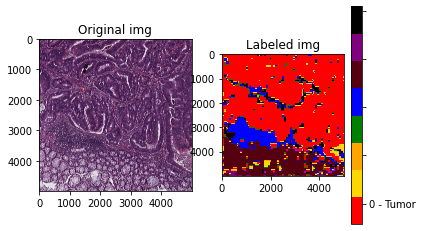

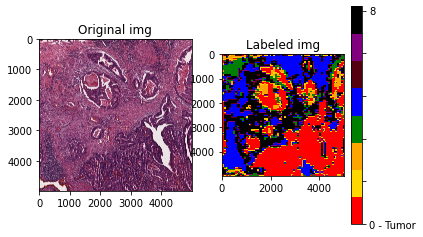

In [450]:

colors =["red","gold", "orange", 
         "green", "blue",  
        "#550011", "purple",
         "black"]
  

cmap1 = cm.colors.ListedColormap(colors)

plot_images(cmap1, seg_images_list, 0)

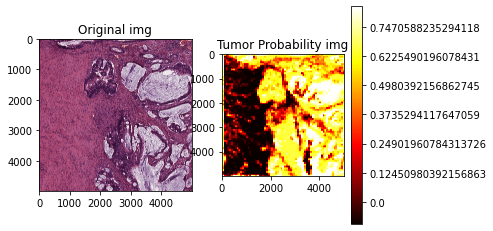

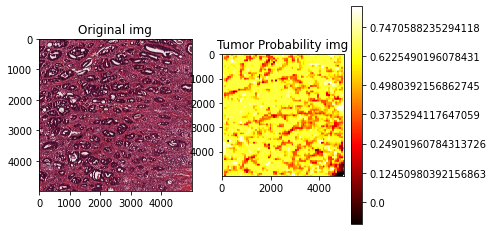

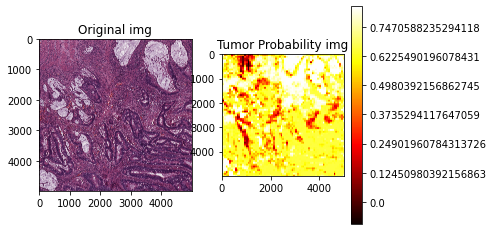

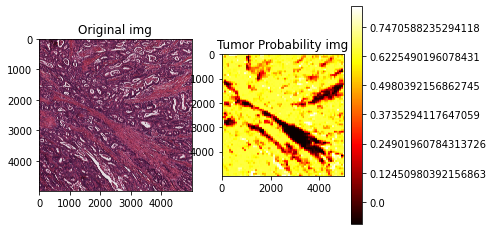

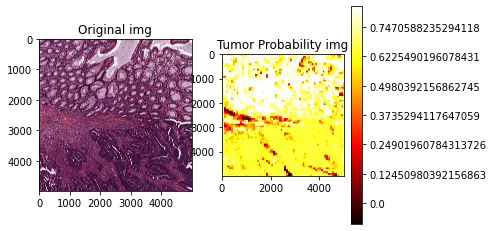

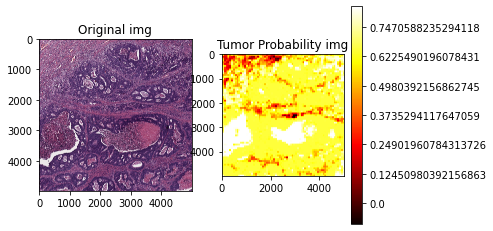

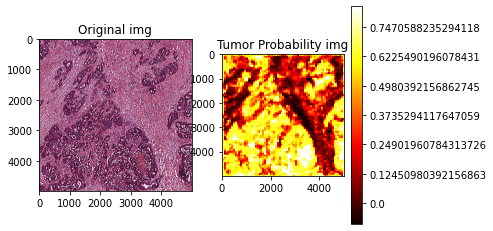

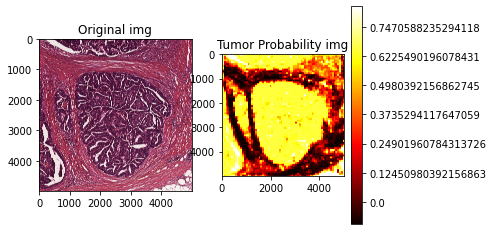

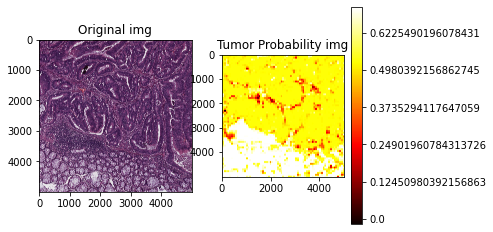

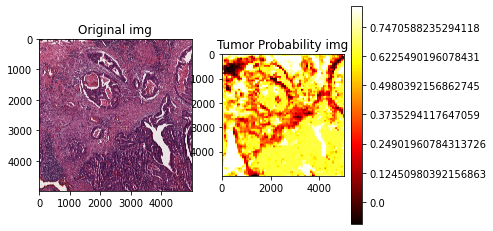

In [452]:
plot_images('hot', cmap_images_list, 1)

https://www.geeksforgeeks.org/matplotlib-colors-listedcolormap-class-in-python/